# IFS paper plots

In [1]:
import numpy as np
import glob,os
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times',size=15)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure',titlesize=25)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['axes.linewidth'] = 2.
from astropy.io import fits

import logging as log
from crispy.tools.initLogger import getLogger
log = getLogger('main')
from crispy.tools.image import Image
os.chdir('/Users/mrizzo/IFS/crispy/crispy/WFIRST/')
from params import Params
import scipy as sp

par = Params()
par.hdr
cmap = 'inferno'#'gray_r'

Populating the interactive namespace from numpy and matplotlib


In [2]:
lensX=10
lensY=10

from crispy.tools.locate_psflets import PSFLets
from crispy.tools.reduction import get_cutout
# polychromeR = fits.open(par.wavecalDir + 'polychromeR%d.fits.gz' % (par.R))
polychromeR = fits.open(par.wavecalDir + 'polychromeR%d.fits' % (par.R))
psflets = polychromeR[0].data
psftool = PSFLets()
lamlist = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 0]
allcoef = np.loadtxt(par.wavecalDir + "lamsol.dat")[:, 1:]

# lam in nm
psftool.geninterparray(lamlist, allcoef)

xlist = []
ylist = []
for lam in lamlist:
    _x,_y = psftool.return_locations(lam, allcoef, lensX, lensY)
    xlist += [_x]    
    ylist += [_y]    

im = Image(filename = par.wavecalDir + 'polychromeR%dstack.fits.gz' % (par.R))
subim, psflet_subarr, [x0, x1, y0, y1] = get_cutout(im,xlist,ylist,psflets)


crispy - INFO - Read data from HDU 0 of ..//ReferenceFiles/wavecalR50_660/polychromeR50stack.fits.gz


In [3]:
for i in range(psflet_subarr.shape[0]):
    psflet_subarr[i] /= np.sum(psflet_subarr[i])


11


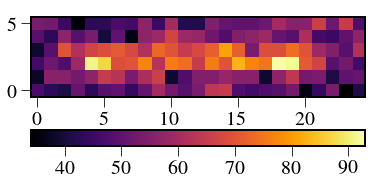

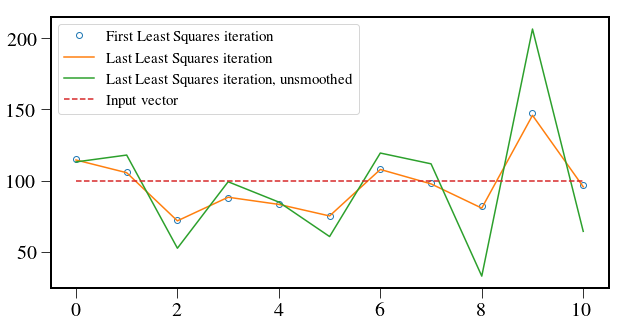

In [4]:
import scipy as sp
psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
A = psflets_flat.T
N = psflet_subarr.shape[0]
Niter = 50
print N
lstsq = np.zeros((N,Niter+1))
lstsq_notsmoothed = np.zeros((N,Niter+1))


pixnoise = 50
vect = np.ones(N)*100
pimg = np.random.poisson(np.sum(psflet_subarr*vect[:,np.newaxis,np.newaxis],axis=0)+pixnoise)
plt.imshow(pimg,cmap=cmap)
plt.colorbar(orientation='horizontal')


img = pimg-pixnoise
sumpix = np.sum(img)
lstsq[:,0] = np.ones(N)*sumpix/float(N)/2
lstsq_notsmoothed[:,0] = np.ones(N)*sumpix/float(N)/2
for i in range(Niter):
    prev = lstsq[:,i]
    variance = np.reshape(np.sum(psflet_subarr*prev[:,np.newaxis,np.newaxis],axis=0)+pixnoise,-1)
    Ninv = np.diag(1./(variance+1e-10))
    Cinv = np.dot(A.T,np.dot(Ninv,A))
    C = np.linalg.inv(Cinv)
    Q = sp.linalg.sqrtm(Cinv)
    s = np.sum(Q,axis=0)
    R = Q/s[:,np.newaxis]
    x = np.reshape(img,-1)
    right = np.dot(A.T,np.dot(Ninv,x))
    f = np.dot(C,right)
    lstsq_notsmoothed[:,i+1] = f
    lstsq[:,i+1] = np.dot(R,f)
outvect = np.dot(R,vect)
plt.figure(figsize=(10,5))
plt.plot(lstsq[:,1],linestyle='none',marker='o',markerfacecolor='none',label="First Least Squares iteration")
plt.plot(lstsq[:,-1],label="Last Least Squares iteration")
plt.plot(lstsq_notsmoothed[:,-1],label="Last Least Squares iteration, unsmoothed")
plt.plot(outvect[:],'--',label="Input vector")
plt.legend()

0.895873906542
0.878101909731


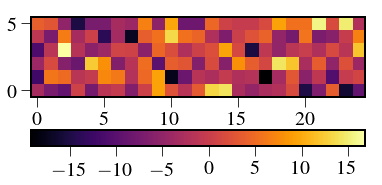

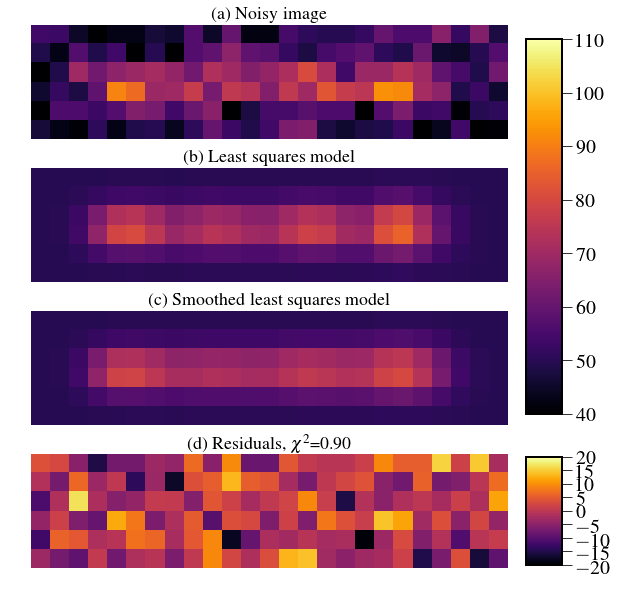

In [5]:
plt.figure()
final = lstsq[:,-1]
model = pixnoise+np.sum(psflet_subarr*final[:,np.newaxis,np.newaxis],axis=0)
model_notsmoothed = pixnoise+np.sum(psflet_subarr*final[:,np.newaxis,np.newaxis],axis=0)
res = pimg-model
plt.imshow(res,cmap=cmap)
plt.colorbar(orientation='horizontal')

chi2 = np.sum(res**2/model)/np.prod(res.shape)
chi2_notsmoothed = np.sum((pimg)**2/model)/np.prod(res.shape)
print chi2

fig, axarr = plt.subplots(4,1,figsize=(10,10))
axarr[0].axis('off')
axarr[0].set_title('(a) Noisy image')
im = axarr[0].imshow(pimg,cmap=cmap,vmin=40,vmax=110)

axarr[2].imshow(model,cmap=cmap,vmin=40,vmax=110)
axarr[2].set_title('(c) Smoothed least squares model')
axarr[2].axis('off')
axarr[1].axis('off')
final = lstsq_notsmoothed[:,-1]
model_notsmoothed = pixnoise+np.sum(psflet_subarr*final[:,np.newaxis,np.newaxis],axis=0)
chi2_notsmoothed = np.sum((pimg-model_notsmoothed)**2/model_notsmoothed)/np.prod(res.shape)
print chi2_notsmoothed

axarr[1].imshow(model_notsmoothed,cmap=cmap,vmin=40,vmax=110)
axarr[1].set_title('(b) Least squares model')

axarr[3].axis('off')
axarr[3].set_title('(d) Residuals, $\chi^2$={:.2f}'.format(chi2))
im2 = axarr[3].imshow(res,cmap=cmap,vmin=-20,vmax=20)

fig.subplots_adjust(right=0.8,wspace=0.1,hspace=0.25)
cbar_ax = fig.add_axes([0.82, 0.34, 0.05, 0.52])
fig.colorbar(im, cax=cbar_ax)
cbar_ax = fig.add_axes([0.82, 0.13, 0.05, 0.15])
fig.colorbar(im2, cax=cbar_ax)

fig.savefig('/Users/mrizzo/Downloads/Microspectrum_Extraction.pdf',dpi=150,bbox_inches='tight')

crispy - INFO - Reduced cube will have 11 wavelength bins
MSE= 0.00523862108202


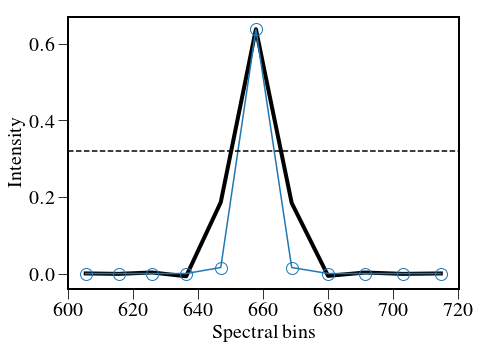

In [20]:
import pandas as pd
from crispy.tools.reduction import calculateWaveList
from scipy import signal
plt.figure(figsize=(7,5))
pd.DataFrame(data=R)
lam_midpts,_ = calculateWaveList(par,method='lstsq')
plt.plot(lam_midpts,R[N/2,:],lw=4,label='Measured spectrograph resolution',color='k')
plt.plot(lam_midpts,signal.gaussian(N, std=19./11./2./2.35)*np.amax(R[N/2,:]),label='Gaussian of FWHM=2',marker='o',
     markerfacecolor='none', markersize=12)
plt.axhline(y=np.amax(R[N/2,:])/2,color='k',linestyle='dashed')
# plt.text(610,0.23,"Half Maximum",fontsize=20)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
# plt.title('Instrument line function')
plt.savefig('/Users/mrizzo/Downloads/Instrument_Line_Function.pdf',dpi=150,bbox_inches='tight')
MSE = np.sum((R[N/2,:]-signal.gaussian(N, std=19./11./2./2.35)*np.amax(R[N/2,:]))**2)/len(R[N/2,:])
print "MSE=",MSE
np.savetxt('/Users/mrizzo/Downloads/Rmatrix%d.txt'%(N),R)
# plt.plot(R[2,:],linestyle='dotted')
# plt.plot(R[-3,:],linestyle='dotted')
# plt.axvline(x=10,color='red',linestyle='dashed')
# plt.axvline(x=8,color='red',linestyle='dashed')
# plt.legend()

crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Reduced cube will have 19 wavelength bins


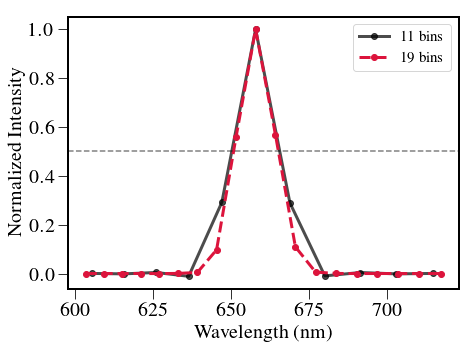

In [36]:
plt.figure(figsize=(7,5))
par.nchanperspec_lstsq=1.2
lam_midpts,_ = calculateWaveList(par,method='lstsq')
R11 = np.loadtxt('/Users/mrizzo/Downloads/Rmatrix11.txt')
N=11
plt.plot(lam_midpts,R11[N/2,:]/np.amax(R11[N/2,:]),lw=3,label='11 bins',color='k',alpha=0.7,marker='o')
R19 = np.loadtxt('/Users/mrizzo/Downloads/Rmatrix19.txt')
par.nchanperspec_lstsq=2.0
lam_midpts,_ = calculateWaveList(par,method='lstsq')
N=19
plt.plot(lam_midpts,R19[N/2,:]/np.amax(R19[N/2,:]),lw=3,linestyle='dashed',marker='o',label='19 bins',color='crimson')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Intensity')
plt.axhline(y=0.5,color='k',linestyle='dashed',alpha=0.5)
plt.legend()
plt.savefig('/Users/mrizzo/Downloads/Instrument_Line_Function_Compare.pdf',dpi=150,bbox_inches='tight')


# SNR computation

In [58]:
psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
A = psflets_flat.T
N = psflet_subarr.shape[0]
Niter = 5
print N

pixnoise = 50
vect = np.ones(N)*100*19./N
def SNRcalc(vect,pixnoise,ntrials):
    lstsq_notsmoothed = np.zeros((N,ntrials,Niter+1))
    lstsq = np.zeros((N,ntrials,Niter+1))
    varlstsq = np.zeros((N,ntrials,Niter+1))
    Rvect = np.zeros((N,ntrials,Niter+1))
    for j in range(ntrials):
        pimg = np.random.poisson(np.sum(psflet_subarr*vect[:,np.newaxis,np.newaxis],axis=0)+pixnoise)
        img = pimg-pixnoise
        sumpix = np.sum(img)
        lstsq[:,j,0] = np.ones(N)*sumpix/float(N)/2
        for i in range(Niter):
            prev = lstsq[:,j,i]
            variance = np.reshape(np.sum(psflet_subarr*prev[:,np.newaxis,np.newaxis],axis=0)+pixnoise,-1)
            Ninv = np.diag(1./(variance+1e-10))
            Cinv = np.dot(A.T,np.dot(Ninv,A))
            C = np.linalg.inv(Cinv)
            Q = sp.linalg.sqrtm(Cinv)
            s = np.sum(Q,axis=0)
            R = Q/s[:,np.newaxis]
            x = np.reshape(img,-1)
            varlstsq[:,j,i+1] = 1./(s**2+1e-10)
            right = np.dot(A.T,np.dot(Ninv,x))
            f = np.dot(C,right)
            lstsq_notsmoothed[:,j,i+1] = f
            lstsq[:,j,i+1] = np.dot(R,f)
            Rvect[:,j,i+1] = np.dot(R,vect)
    return lstsq,lstsq_notsmoothed,varlstsq,Rvect


11


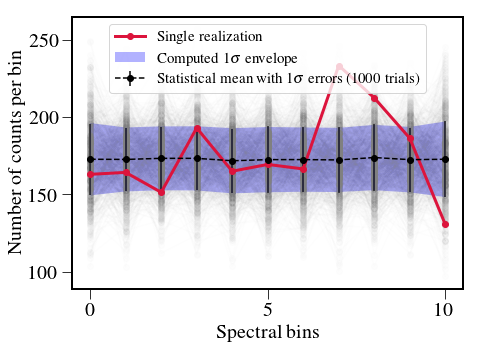

In [59]:
lstsq,lstsq_notsmoothed,varlstsq,Rvect = SNRcalc(vect,pixnoise,ntrials=1000)
lstsq = lstsq[:,:,-1]
varlstsq = varlstsq[:,:,-1]
Rvect = Rvect[:,:,-1]
lstsq_notsmoothed = lstsq_notsmoothed[:,:,-1]
np.savetxt('/Users/mrizzo/Downloads/lstsq%d.txt'%(N),lstsq)
np.savetxt('/Users/mrizzo/Downloads/varlstsq%d.txt'%(N),varlstsq)
np.savetxt('/Users/mrizzo/Downloads/Rvect%d.txt'%(N),Rvect)
np.savetxt('/Users/mrizzo/Downloads/lstsq_notsmoothed%d.txt'%(N),lstsq_notsmoothed)

plt.figure(figsize=(7,5))
plt.plot(lstsq,color='gray',alpha=0.01,marker='o')
plt.plot(np.arange(N),lstsq[:,-2],'-o',color='crimson',lw=3,label='Single realization')
plt.fill_between(np.arange(N), np.mean(lstsq,axis=1)-np.sqrt(varlstsq[:,-1]), np.mean(lstsq,axis=1)+np.sqrt(varlstsq[:,-1]),alpha=0.3,facecolor='blue',label='Computed 1$\sigma$ envelope')
plt.errorbar(np.arange(N),np.mean(lstsq,axis=1),yerr=np.std(lstsq,axis=1),label='Statistical mean with 1$\sigma$ errors (1000 trials)',color='k',marker='o',linestyle='dashed')
plt.legend(fontsize=15)
plt.ylabel('Number of counts per bin')
plt.xlabel('Spectral bins')
plt.xticks(range(0,N,5))
plt.savefig('/Users/mrizzo/Downloads/Errorbars.pdf',dpi=150,bbox_inches='tight')

crispy - INFO - Reduced cube will have 11 wavelength bins
[ 172.68913212  172.5621709   173.27059043  173.25384699  171.7039103
  172.43301376  172.45273913  172.24737764  173.79174915  172.41272738
  172.68369981]
crispy - INFO - Reduced cube will have 19 wavelength bins


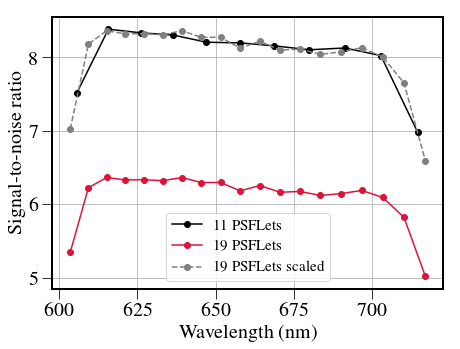

In [79]:
var11 = np.loadtxt('/Users/mrizzo/Downloads/varlstsq11.txt')
var19 = np.loadtxt('/Users/mrizzo/Downloads/varlstsq19.txt')
res11 = np.loadtxt('/Users/mrizzo/Downloads/lstsq11.txt')
res19 = np.loadtxt('/Users/mrizzo/Downloads/lstsq19.txt')
par.nchanperspec_lstsq=1.2
lam_midpts,_ = calculateWaveList(par,method='lstsq')
plt.figure(figsize=(7,5))
print np.mean(res11,axis=1)
plt.plot(lam_midpts,np.mean(res11,axis=1)/np.sqrt(np.mean(var11,axis=1)),'k',label='11 PSFLets',marker='o',)
par.nchanperspec_lstsq=2.0
lam_midpts,_ = calculateWaveList(par,method='lstsq')
plt.plot(lam_midpts,np.mean(res19,axis=1)/np.sqrt(np.mean(var19,axis=1)),'crimson',marker='o',label='19 PSFLets')
plt.plot(lam_midpts,np.mean(res19,axis=1)/np.sqrt(np.mean(var19,axis=1))*np.sqrt(19./11.),linestyle='dashed',marker='o',color='gray',label='19 PSFLets scaled')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Signal-to-noise ratio')
plt.legend()
plt.grid()
plt.savefig('/Users/mrizzo/Downloads/BinningImpactonSNR.pdf',dpi=150,bbox_inches='tight')

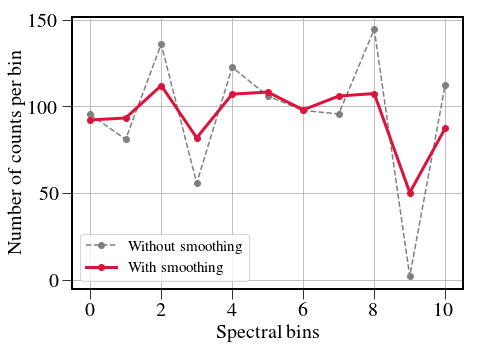

In [14]:
plt.figure(figsize=(7,5))
plt.plot(lstsq_notsmoothed[:,-2],color='gray',marker='o',linestyle='dashed',label='Without smoothing')
plt.plot(np.arange(N),lstsq[:,-2],'-o',color='crimson',lw=3,label='With smoothing')
plt.grid('on')
plt.legend()
plt.ylabel('Number of counts per bin')
plt.xlabel('Spectral bins')
plt.savefig('/Users/mrizzo/Downloads/With-WithoutSmoothing.pdf',dpi=150,bbox_inches='tight')

# SNR and background pixels

9.64375347879 3.02965888448
19
5.18181818182


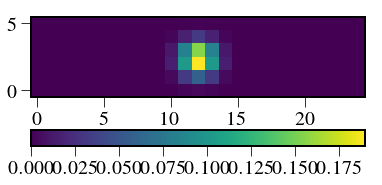

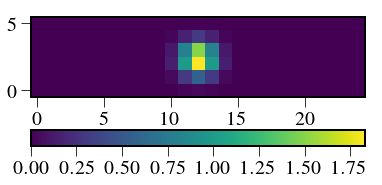

In [115]:
test = psflet_subarr[9].copy()
# test /= np.amax(test)
test /= np.sum(test)
print 1./np.sum(test**2),1./np.sum((test[:,12]/np.sum(test[:,12]))**2)
plt.imshow(test)
plt.colorbar(orientation='horizontal')
plt.figure()
test /= np.sum(test**2)
plt.imshow(test)
plt.colorbar(orientation='horizontal')

print len(psflet_subarr)
print 3*19./11.


The simulation to do here is the following:
1. Calculate background pixels for the central bin for many trials
2. Repeat for several sampling

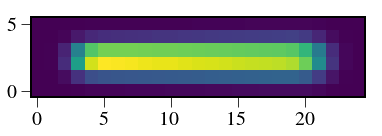

In [13]:
vect = np.ones(N)*100*19./N
tot = np.sum(psflet_subarr*vect[:,np.newaxis,np.newaxis],axis=0)
plt.imshow(tot)

In [14]:
tot /= np.sum(tot)
Npix = 1./np.sum(tot**2)
print Npix

58.1864718229


In [111]:
print Npix/19
print (Npix-9.6)/(N-2)

3.06244588542
2.85802775429


In [109]:
print 8.9/5.3
print 5.2/3.06

1.67924528302
1.69934640523


In [236]:
print N


def SNRcalcBeta(vect,pixnoise,ntrials,Niter=5,psflets = psflet_subarr):
    psflets_flat = np.reshape(psflets, (psflets.shape[0], -1))
    A = psflets_flat.T
    N = psflets.shape[0]

    lstsq_notsmoothed = np.zeros((N,ntrials,Niter+1))
    lstsq = np.zeros((N,ntrials,Niter+1))
    varlstsq = np.zeros((N,ntrials,Niter+1))
    Rvect = np.zeros((N,ntrials,Niter+1))
    beta = np.zeros((N,ntrials,Niter+1))
    for j in range(ntrials):
        pimg = np.random.poisson(np.sum(psflets*vect[:,np.newaxis,np.newaxis],axis=0)+pixnoise)
        img = pimg-pixnoise
        sumpix = np.sum(img)
        lstsq[:,j,0] = np.ones(N)*sumpix/float(N)/2
        if j%(max(ntrials/10,1))==0: print j,"/",ntrials
        for i in range(Niter):
            prev = lstsq[:,j,i]
            variance = np.reshape(np.sum(psflets*prev[:,np.newaxis,np.newaxis],axis=0)+pixnoise,-1)
            Ninv = np.diag(1./(variance+1e-10))
            Cinv = np.dot(A.T,np.dot(Ninv,A))
            C = np.linalg.inv(Cinv)
            Q = sp.linalg.sqrtm(Cinv)
            s = np.sum(Q,axis=0)
            R = Q/s[:,np.newaxis]
            x = np.reshape(img,-1)
            varlstsq[:,j,i+1] = 1./(s**2+1e-10)
            right = np.dot(A.T,np.dot(Ninv,x))
            f = np.dot(C,right)
            lstsq_notsmoothed[:,j,i+1] = f
            lstsq[:,j,i+1] = np.dot(R,f)
            Rvect[:,j,i+1] = np.dot(R,vect)
            beta[:,j,i+1] = (varlstsq[:,j,i+1]-lstsq[:,j,i+1])/pixnoise
    return lstsq,lstsq_notsmoothed,varlstsq,Rvect,beta


19


In [ ]:
# Slist = [10.,50.,100,200,500,1000,10000]
Slist = [2.,4.,8.,16.,32.,64.,128.,256.]
ntrials = 1000
fig1,ax1 = plt.subplots()
fig2,ax2 = plt.subplots()
for pxnoise in [0]:
    betalist = []
    SNR = []
    for S in Slist:
        vect=np.ones(N)*S*19./N
        lstsq,_,varlstsq,_,beta = SNRcalcBeta(vect,pxnoise,ntrials=ntrials)
        ax1.plot(np.mean(beta[:,:,-1],axis=1),label='Pixnoise=%d, S=%d'%(pxnoise,S))
        ax1.set_ylabel('Number of equivalent noise pixels')
        ax2.plot(np.mean(lstsq[:,:,-1]/np.sqrt(varlstsq[:,:,-1]),axis=1),label='Pixnoise=%d, S=%d'%(pxnoise,S))
        ax2.plot(np.sqrt(S))
#         ax2.errorbar(np.arange(N),np.mean(lstsq[:,:,-1],axis=1),yerr=np.std(lstsq[:,:,-1],axis=1),label='Statistical mean with 1$\sigma$ errors (1000 trials)',color='k',marker='o',linestyle='dashed')
        ax2.set_ylabel('SNR')
        betalist.append(np.mean(beta[N/2,:,-1]))
        SNR.append(np.mean(lstsq[N/2,:,-1]/np.sqrt(varlstsq[N/2,:,-1])))

Text(0,0.5,u'Number of equivalent noise pixels')

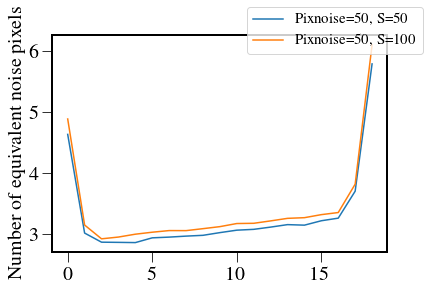

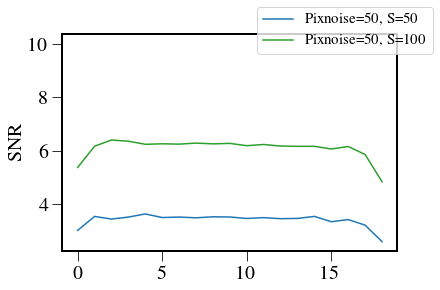

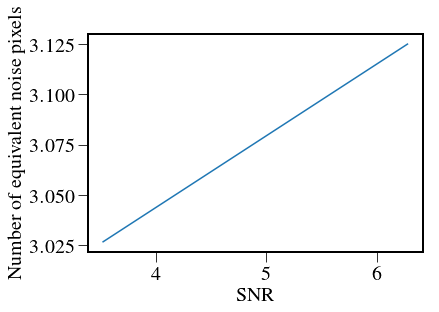

In [167]:
fig1.legend()
fig2.legend()
plt.figure()
plt.plot(SNR,betalist)
plt.xlabel('SNR')
plt.ylabel('Number of equivalent noise pixels')

## Study the background pixels as a function of background electrons per pixel

In [118]:
# Slist = [10.,50.,100,200,500,1000,10000]
Slist = [100]
# pxlist = [1.,10.,50,100,500,1000,2000,3000,4000,5000]
pxlist = [1,5,10.,25,50,75,100,150,250,500]
ntrials = 1000
# fig1,ax1 = plt.subplots()
# fig2,ax2 = plt.subplots()
for S in Slist:
    SNR = []
    SNRlast = []
    SNR_stat = []
    betalist = []
    betalast =[]
    for pxnoise in pxlist:
        vect=np.ones(N)*S*19./N
        lstsq,_,varlstsq,_,beta = SNRcalcBeta(vect,pxnoise,ntrials=ntrials)
#         ax1.plot(np.mean(beta[:,:,-1],axis=1),label='Pixnoise=%d, S=%d'%(pxnoise,S))
#         ax1.set_ylabel('Number of equivalent noise pixels')
#         ax2.plot(np.mean(lstsq[:,:,-1]/np.sqrt(varlstsq[:,:,-1]),axis=1),label='Pixnoise=%d, S=%d'%(pxnoise,S))
#         ax2.plot(np.sqrt(S))
# #         ax2.errorbar(np.arange(N),np.mean(lstsq[:,:,-1],axis=1),yerr=np.std(lstsq[:,:,-1],axis=1),label='Statistical mean with 1$\sigma$ errors (1000 trials)',color='k',marker='o',linestyle='dashed')
#         ax2.set_ylabel('SNR')
        betalist.append(np.mean(beta[N/2,:,-1]))
        SNR.append(np.mean(lstsq[N/2,:,-1]/np.sqrt(varlstsq[N/2,:,-1])))
        SNR_stat.append(np.mean(lstsq[N/2,:,-1]/np.std(lstsq[N/2,:,-1])))
        betalast.append(np.mean(beta[-1,:,-1]))
        SNRlast.append(np.mean(lstsq[-1,:,-1]/np.sqrt(varlstsq[-1,:,-1])))
# fig1.legend()
# fig2.legend()

3.06244588542


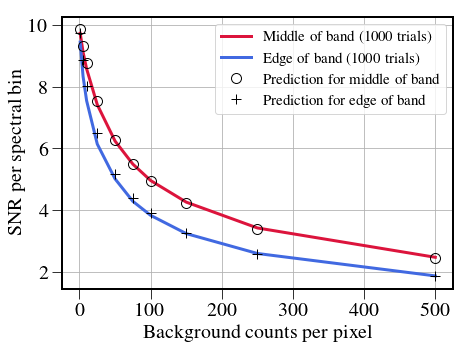

In [142]:
plt.figure(figsize=(7,5))
plt.plot(pxlist,SNR,label='Middle of band (%d trials)'%ntrials,color='crimson',lw=3)
# plt.plot(pxlist,SNR_stat,label='Statistical SNR (%d trials)'%ntrials)
plt.plot(pxlist,SNRlast,label='Edge of band (%d trials)'%ntrials,color='royalblue',lw=3)
plt.plot(pxlist,Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*np.array(pxlist))),label='Prediction for middle of band',linestyle='none',marker='o',markersize=10,markerfacecolor='none',color='k')
plt.plot(pxlist,Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*1.8*np.array(pxlist))),label='Prediction for edge of band',linestyle='none',marker='+',markersize=10,markerfacecolor='none',color='k')
plt.xlabel('Background counts per pixel')
plt.ylabel('SNR per spectral bin')
plt.grid('on')
plt.legend()
plt.savefig('/Users/mrizzo/Downloads/BackgroundPixels.pdf',dpi=150,bbox_inches='tight')
print Npix/N

[9.7181679232022358, 9.1119319401944114, 8.5716994276229102, 7.4134085983822837, 6.237503603598368, 5.4938025730407603, 4.9639893465927418, 4.2663219790928686, 3.4323597735576903, 2.4850431992452053]
[ 9.85030726  9.31241487  8.74959091  7.52579578  6.2854272   5.50746103
  4.96142243  4.22816206  3.39890087  2.47595838]
10.0


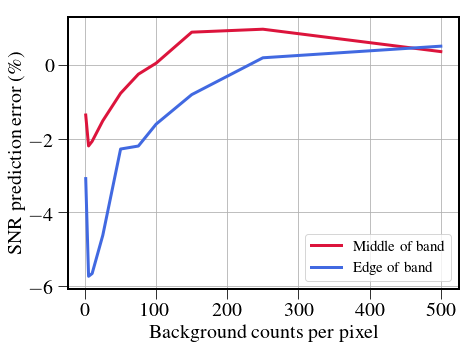

In [166]:
plt.figure(figsize=(7,5))
plt.plot(pxlist,(SNR-Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*np.array(pxlist))))/SNR*100.,
         label='Middle of band',color='crimson',lw=3)
plt.plot(pxlist,(SNRlast-Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*1.8*np.array(pxlist))))/SNR*100.,
         label='Edge of band',color='royalblue',lw=3)
plt.grid('on')
plt.ylabel('SNR prediction error (\%)')
plt.xlabel('Background counts per pixel')
plt.legend()
print SNR
print Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*np.array(pxlist)))
print Slist[0]*19./N/(np.sqrt(Slist[0]*19./N))

Text(0,0.5,u'Equivalent $\\beta$')

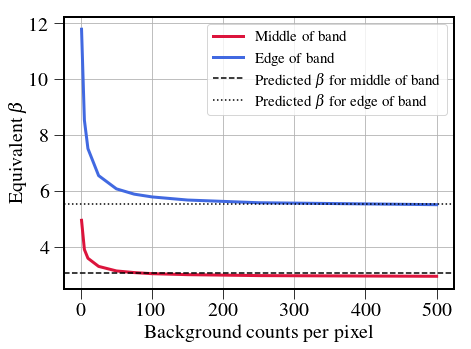

In [157]:
plt.figure(figsize=(7,5))
# plt.plot(pxlist[1:],np.array(betalist[1:])*np.array(pxlist[1:]))
plt.plot(pxlist,np.array(betalist),color='crimson',label='Middle of band',lw=3)
plt.plot(pxlist,np.array(betalast),color='royalblue',label='Edge of band',lw=3)
plt.axhline(y=Npix/N,linestyle='--',label=r"Predicted $\beta$ for middle of band",color='black')
plt.axhline(y=Npix/N*1.8,linestyle=':',label=r"Predicted $\beta$ for edge of band",color='black')
plt.legend()
plt.grid('on',which='both')
plt.xlabel('Background counts per pixel')
plt.ylabel(r'Equivalent $\beta$')


[500.0, 250.0, 150.0, 100.0, 75.0, 50.0, 25.0, 10.0, 5.0, 1.0]
[9.7181679232022358, 9.1119319401944114, 8.5716994276229102, 7.4134085983822837, 6.237503603598368, 5.4938025730407603, 4.9639893465927418, 4.2663219790928686, 3.4323597735576903, 2.4850431992452053]
[4.943188023717223, 3.8964409196405048, 3.5817811328635392, 3.290539117721706, 3.1276250343040859, 3.0687989476741304, 3.0292280614298215, 2.994209415728462, 2.9604589269212838, 2.9354025923457581] [11.794249288731324, 8.5356133776440046, 7.5122751082333226, 6.545240890528615, 6.0708649536764829, 5.8807527783680182, 5.7815623989377407, 5.6695772399958608, 5.5727231798362205, 5.5032597250380855]
1.87478873916


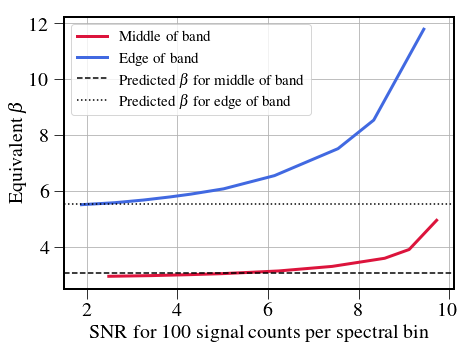

In [158]:
fig,ax = plt.subplots(figsize=(7,5))
# plt.plot(pxlist[1:],np.array(betalist[1:])*np.array(pxlist[1:]))
ax.plot(SNR,np.array(betalist),color='crimson',label='Middle of band',lw=3)
ax.plot(SNRlast,np.array(betalast),color='royalblue',label='Edge of band',lw=3)
# ax2 = ax.twiny()
# ax2.plot(pxlist, np.ones(len(pxlist))) # Create a dummy plot
# ax2.cla()
invpxlist = list(np.array(pxlist)[::-1])
print invpxlist
print SNR
def tick_function(X):
    return ["%d" % z for z in X]

# ax2.set_xticks(SNR)
# ax2.set_xticklabels(tick_function(pxlist))
# ax2.set_xlabel("Number of background counts")

plt.axhline(y=Npix/N,linestyle='--',label=r"Predicted $\beta$ for middle of band",color='black')
plt.axhline(y=Npix/N*1.8,linestyle=':',label=r"Predicted $\beta$ for edge of band",color='black')
ax.legend()
ax.grid('on',which='both')
ax.set_xlabel('SNR for 100 signal counts per spectral bin')
ax.set_ylabel(r'Equivalent $\beta$')
print betalist,betalast
print betalast[-1]/betalist[-1]

## More on SNR when there is no noise background: IFS maximal extraction efficiency $\eta$

In [202]:
Slist = [x**2 for x in range(2,17,2)]#[2.,4.,8.,16.,32.,64.,128.,256.]
ntrials = 1000
for pxnoise in [0]:
    SNR_nonoise = []
    for S in Slist:
        vect=np.ones(N)*S*19./N
        lstsq,_,varlstsq,_,_ = SNRcalcBeta(vect,pxnoise,ntrials=ntrials)
        SNR_nonoise.append(np.mean(lstsq[N/2,:,-1]/np.sqrt(varlstsq[N/2,:,-1])))


[-0.04878409 -0.01530604 -0.00599823  0.01546714 -0.02253229  0.01594308
 -0.03621935 -0.03107108] [1.9512159089708676, 3.9846939571868139, 5.9940017724324504, 8.0154671410631337, 9.977467714515436, 12.015943084948438, 13.963780653018409, 15.968928921176269]


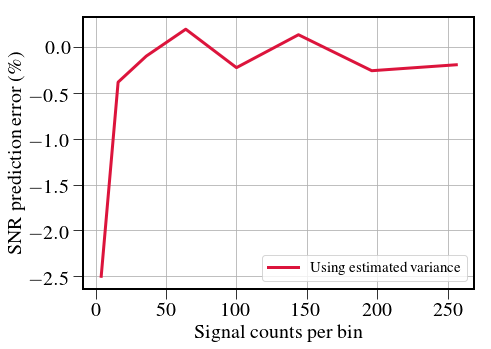

In [203]:
plt.figure(figsize=(7,5))
plt.plot(Slist,(SNR_nonoise-np.sqrt(Slist))/SNR_nonoise*100,label='Using estimated variance',color='crimson',lw=3)
print (SNR_nonoise-np.sqrt(Slist)), SNR_nonoise#/SNR*100
# plt.plot(Slist,(SNR_comp-np.sqrt(Slist))/SNR_comp*100,label='Using computed variance from trials',color='royalblue',lw=3)
# plt.plot(Slist,np.sqrt(Slist),label='Predicted SNR',color='royalblue',lw=3)

# plt.plot(pxlist,SNR_stat,label='Statistical SNR (%d trials)'%ntrials)
# plt.plot(pxlist,SNRlast,label='Edge of band (%d trials)'%ntrials,color='royalblue',lw=3)
# plt.plot(pxlist,Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*np.array(pxlist))),label='Prediction for middle of band',linestyle='none',marker='o',markersize=10,markerfacecolor='none',color='k')
# plt.plot(pxlist,Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*1.8*np.array(pxlist))),label='Prediction for edge of band',linestyle='none',marker='+',markersize=10,markerfacecolor='none',color='k')
plt.xlabel('Signal counts per bin')
plt.ylabel('SNR prediction error (\%)')
plt.grid('on')
plt.legend()


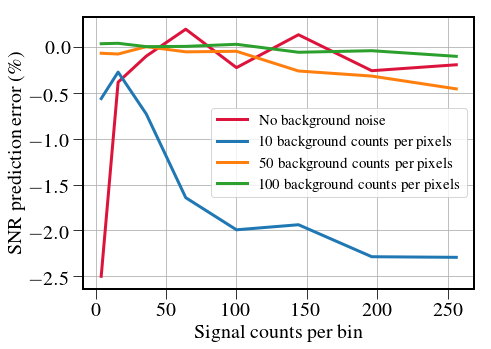

In [212]:
ntrials = 1000
plt.figure(figsize=(7,5))
plt.plot(Slist,(SNR_nonoise-np.sqrt(Slist))/SNR_nonoise*100,label='No background noise',color='crimson',lw=3)

for pxnoise in [10,50,100]:
    SNR_noise = []
    for S in Slist:
        vect=np.ones(N)*S*19./N
        lstsq,_,varlstsq,_,_ = SNRcalcBeta(vect,pxnoise,ntrials=ntrials)
        SNR_noise.append(np.mean(lstsq[N/2,:,-1]/np.sqrt(varlstsq[N/2,:,-1])))
        
    plt.plot(Slist,(np.array(SNR_noise)-np.array(Slist)*19./N/(np.sqrt(np.array(Slist)*19./N+Npix/N*pxnoise)))/pxnoise*100.,
         label='%d background counts per pixels'%pxnoise,lw=3)
plt.xlabel('Signal counts per bin')
plt.ylabel('SNR prediction error (\%)')
plt.grid('on')
plt.legend()
plt.savefig('/Users/mrizzo/Downloads/SNRPredictionError.pdf',dpi=150,bbox_inches='tight')


# Now let's repeat this with the full-PSF extraction

0.0180089


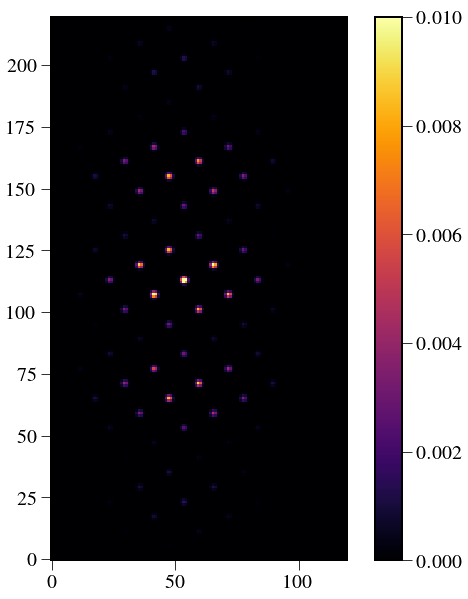

In [5]:
folder = '/Users/mrizzo/IFS/Extraction/'
PSF_polychrome = fits.open(folder+'/PSF_polychrome.fits')[1].data
PSF_polychrome_cut = PSF_polychrome[:,400:620,570:690]
PSF = np.zeros_like(PSF_polychrome_cut)
for i in range(PSF.shape[0]):
    PSF[i] = PSF_polychrome_cut[i]/np.sum(PSF_polychrome_cut[i])
print np.amax(PSF[0])
plt.figure(figsize=(10,10))
plt.imshow(PSF[0],vmin = 0.0,vmax=0.01,cmap=cmap)
plt.colorbar()

(-0.5, 34.5, -0.5, 64.5)

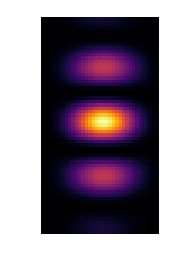

In [49]:
offaxis_psf_filename='/Users/mrizzo/IFS/OS5/offaxis/spc_offaxis_psf.fits'
offaxis = fits.open(offaxis_psf_filename)[0].data
plt.imshow(offaxis[0,95:160,180:215],cmap=cmap)
plt.axis('off')

1.0
114.516143585


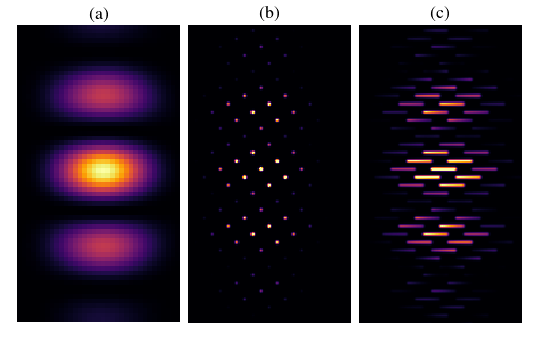

In [56]:
N=PSF.shape[0]
vect = np.ones(N)*100*19./N
tot = np.sum(PSF*vect[:,np.newaxis,np.newaxis],axis=0)
tot/=np.sum(tot)
totpower = np.sum(tot)
print totpower
print 1./np.sum(tot**2)/N
Npix = 1./np.sum(tot**2)
# plt.figure(figsize=(7,15))
# mask = tot<np.amax(tot)/4
# tot[mask]=0
# print np.sum(tot)

# tot/=np.sum(tot)
# print 1./np.sum(tot**2)/N
# plt.imshow(tot,cmap=cmap)
# plt.colorbar()
plt.figure(figsize=(7,7))
plt.subplot(131)
plt.imshow(offaxis[0,96:160,180:215],cmap=cmap)
plt.title('(a)')
plt.axis('off')
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.gca().yaxis.set_major_locator(ticker.NullLocator())

plt.subplot(132)
plt.imshow(PSF[0],vmin = 0.0,vmax=0.005,cmap=cmap)
plt.title('(b)')
plt.axis('off')
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.gca().yaxis.set_major_locator(ticker.NullLocator())
plt.subplot(133)
plt.imshow(tot/100,vmax=0.00001,cmap=cmap)
plt.title('(c)')
plt.axis('off')
# plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_axis_off()
plt.margins(0,0)
import matplotlib.ticker as ticker
# plt.gca().xaxis.set_major_locator(NullLocator())
# plt.gca().yaxis.set_major_locator(NullLocator())
plt.gca().xaxis.set_major_locator(ticker.NullLocator())
plt.gca().yaxis.set_major_locator(ticker.NullLocator())

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0.05)
# plt.subplots_adjust(left=0.0,bottom=0.0,top=1.0,wspace=0.05,hspace=0.0)
plt.savefig('/Users/mrizzo/Downloads/FullPSF.pdf',dpi=150,bbox_inches='tight',pad_inches=0)


In [255]:
# Slist = [10.,50.,100,200,500,1000,10000]
Slist = [1000]
# pxlist = [1.,10.,50,100,500,1000,2000,3000,4000,5000]
pxlist = [2**p for p in range(5,10)]
ntrials = 1000
# fig1,ax1 = plt.subplots()
# fig2,ax2 = plt.subplots()
for S in Slist:
    SNR = []
    SNRlast = []
    SNR_stat = []
    betalist = []
    betalast =[]
    for pxnoise in pxlist:
        vect=np.ones(N)*S*19./N
        print pxnoise
        lstsq,_,varlstsq,_,beta = SNRcalcBeta(vect,pxnoise,ntrials=ntrials,psflets=PSF,Niter=3)
#         ax1.plot(np.mean(beta[:,:,-1],axis=1),label='Pixnoise=%d, S=%d'%(pxnoise,S))
#         ax1.set_ylabel('Number of equivalent noise pixels')
#         ax2.plot(np.mean(lstsq[:,:,-1]/np.sqrt(varlstsq[:,:,-1]),axis=1),label='Pixnoise=%d, S=%d'%(pxnoise,S))
#         ax2.plot(np.sqrt(S))
# #         ax2.errorbar(np.arange(N),np.mean(lstsq[:,:,-1],axis=1),yerr=np.std(lstsq[:,:,-1],axis=1),label='Statistical mean with 1$\sigma$ errors (1000 trials)',color='k',marker='o',linestyle='dashed')
#         ax2.set_ylabel('SNR')
        betalist.append(np.mean(beta[N/2,:,-1]))
        SNR.append(np.mean(lstsq[N/2,:,-1]/np.sqrt(varlstsq[N/2,:,-1])))
        SNR_stat.append(np.mean(lstsq[N/2,:,-1]/np.std(lstsq[N/2,:,-1])))
        betalast.append(np.mean(beta[-1,:,-1]))
        SNRlast.append(np.mean(lstsq[-1,:,-1]/np.sqrt(varlstsq[-1,:,-1])))
# fig1.legend()
# fig2.legend()

32
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
64
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
128
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
256
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
512
0 / 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000


In [256]:
print SNR,betalist,SNRlast,betalast

[14.059235992818845, 10.789131357991744, 7.9753190211721439, 5.8527687170406235, 4.1408439419855769] [126.90683778611185, 119.38281923093977, 114.9576659867636, 112.47022784109431, 111.17700154249223] [10.640071654771035, 7.9504471843887643, 5.7907635476834125, 4.1247067005938591, 2.8964487929171554] [243.71891452700737, 231.21228819266338, 224.18732000096432, 220.38343973802216, 218.41562107312296]


In [254]:
print [2**p for p in range(5,10)]
print [x**2 for x in range(5,10)]

[32, 64, 128, 256, 512]


58.1864718229


114.516143585


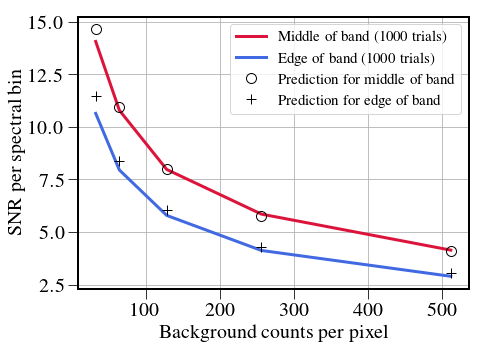

In [265]:
plt.figure(figsize=(7,5))
plt.plot(pxlist,SNR,label='Middle of band (%d trials)'%ntrials,color='crimson',lw=3)
# plt.plot(pxlist,SNR_stat,label='Statistical SNR (%d trials)'%ntrials)
plt.plot(pxlist,SNRlast,label='Edge of band (%d trials)'%ntrials,color='royalblue',lw=3)
plt.plot(pxlist,Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*np.array(pxlist))),label='Prediction for middle of band',linestyle='none',marker='o',markersize=10,markerfacecolor='none',color='k')
plt.plot(pxlist,Slist[0]*19./N/(np.sqrt(Slist[0]*19./N+Npix/N*1.8*np.array(pxlist))),label='Prediction for edge of band',linestyle='none',marker='+',markersize=10,markerfacecolor='none',color='k')
plt.xlabel('Background counts per pixel')
plt.ylabel('SNR per spectral bin')
plt.grid('on')
plt.legend()
plt.savefig('/Users/mrizzo/Downloads/BackgroundPixels_FullPSF.pdf',dpi=150,bbox_inches='tight')
print Npix/N

38.3518341728


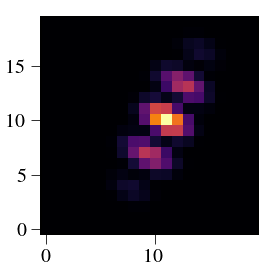

In [66]:
planet_cube=fits.getdata(folder+'planet_cube_optext.fits')
subimg = planet_cube[N/2,40:60,50:70]
# subimg = planet_cube[N/2]
plt.imshow(subimg,cmap=cmap)
tot = subimg/np.nansum(subimg)
print 1./np.nansum(tot**2)

# Comparison between full forward model and regular matched filter